In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import mplcursors
import yfinance as yf
from pathlib import Path
from datetime import date, timedelta, datetime, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def fetch_ticker(ticker="^GSPC", start="1990-01-01", interval="15m"):
    end = date.today()
    if interval == "1h":
        start = end - timedelta(days=720)
    p = Path(f"data/cache/{interval}/{ticker}.csv")
    p.parent.mkdir(parents=True, exist_ok=True)
    if not p.is_file() or date.fromtimestamp(p.stat().st_mtime) < date.today():
        data = yf.download(
            ticker, start=start, end=end, interval=interval, prepost=True
        )
        data.columns = data.columns.droplevel(-1)
        data.to_csv(p)
    else:
        data = pd.read_csv(p, index_col=0, parse_dates=[0])
    return data


df = fetch_ticker("^GSPC", interval="1d", start="1985-01-01")

In [3]:


def get_drawdowns(df:pd.DataFrame):
    df['running_max'] = df['Close'].cummax()
    df['drawdown'] = (df['Close'] - df['running_max']) / df['running_max']
    print(df["drawdown"].min())
    current_drawdown = df['drawdown'].iloc[-1]
    df['in_drawdown'] = df['drawdown'] < 0
    df['drawdown_event'] = (df['in_drawdown'] != df['in_drawdown'].shift(1)).cumsum() * df['in_drawdown']
    events = []
    for event in df['drawdown_event'].unique():
        if event == 0:
            continue  # Skip periods not in drawdown
        event_df = df[df['drawdown_event'] == event]
        
        # Minimum drawdown during this event
        event_min_drawdown = event_df['drawdown'].min()
        
        # Check if this event's minimum drawdown is similar to current drawdown
        if event_min_drawdown <= current_drawdown:
            # The event start date (first day of this drawdown period)
            event_start = event_df.index[0]
            
            # The previous peak is the running max at the start of the event.
            previous_peak = df.loc[event_start, 'running_max']
            
            # Identify the trough date (when the drawdown is deepest during the event)
            trough_date = event_df['drawdown'].idxmin()
            
            # Find the recovery date: first date after trough when Close recovers to (or above) the previous peak.
            recovery_df = df.loc[trough_date:]
            recovery_date = recovery_df[recovery_df['Close'] >= previous_peak].index.min()
            
            # Calculate recovery duration in days if a recovery date was found.
            if pd.notnull(recovery_date):
                recovery_days = (recovery_date - trough_date).days
            else:
                recovery_days = np.nan  # Not recovered yet
            
            events.append({
                'event_start': event_start,
                'trough_date': trough_date,
                'event_min_drawdown': event_min_drawdown,
                'previous_peak': previous_peak,
                'recovery_date': recovery_date,
                'recovery_days': recovery_days
            })
    return events

def plot_drawdowns(events: list[dict]):
    events_df = pd.DataFrame(events)
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    # Plot the Close price and running maximum
    ax.plot(df.index, df['Close'], label='Close Price', color='black')
    ax.plot(df.index, df['running_max'], label='Running Max', color='blue', linestyle='--')

    # Mark events from events_df
    # We use different markers for event start (green triangle), trough (red inverted triangle),
    # and recovery (orange circle). Also, draw a line connecting the trough and recovery.
    for idx, event in events_df.iterrows():
        event_start = event['event_start']
        trough_date = event['trough_date']
        recovery_date = event['recovery_date']
        
        # Plot event start marker
        ax.scatter(event_start, df.loc[event_start, 'Close'], color='green', marker='^', s=100,
                label='Event Start' if idx == 0 else "")
        # Plot trough marker
        ax.scatter(trough_date, df.loc[trough_date, 'Close'], color='red', marker='v', s=100,
                label='Trough' if idx == 0 else "")
        
        # Plot recovery marker and connecting line if recovery occurred
        if pd.notnull(recovery_date):
            ax.scatter(recovery_date, df.loc[recovery_date, 'Close'], color='orange', marker='o', s=100,
                    label='Recovery' if idx == 0 else "")
            ax.plot([trough_date, recovery_date],
                    [df.loc[trough_date, 'Close'], df.loc[recovery_date, 'Close']],
                    color='gray', linestyle='--')
            
    cursor = mplcursors.cursor(hover=True)
    cursor.connect("add", lambda sel: sel.annotation.set_text(
        f"Date: {sel.target[0]:.0f}\nPrice: {sel.target[1]:.2f}"
    ))

    # Set titles and labels
    ax.set_title("Close Price with Drawdown Events")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()

    plt.tight_layout()
    plt.show()


-0.5677538774277282


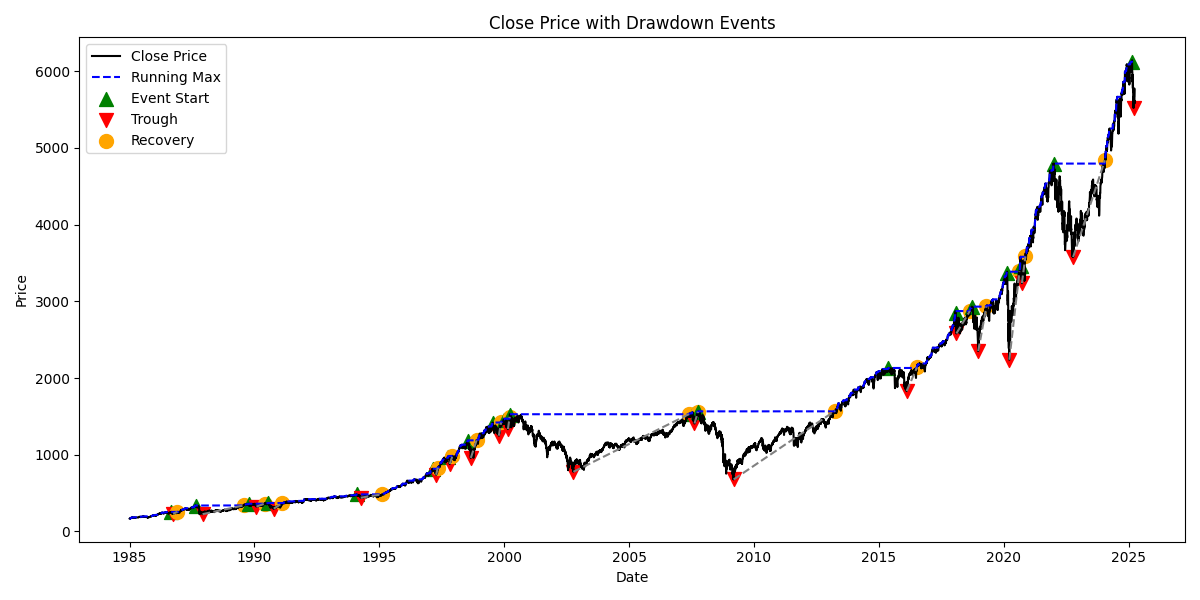

,event_start,trough_date,event_min_drawdown,previous_peak,recovery_date,recovery_days
0,1986-09-05,1986-09-29,-0.094236,253.830002,1986-12-02,64.0
1,1987-08-26,1987-12-04,-0.335095,336.769989,1989-07-26,600.0
2,1989-10-10,1990-01-30,-0.102335,359.799988,1990-05-29,119.0
3,1990-07-17,1990-10-11,-0.199187,368.950012,1991-02-13,125.0
4,1994-02-03,1994-04-04,-0.089378,482.000000,1995-02-14,316.0
5,1997-02-19,1997-04-11,-0.096338,816.289978,1997-05-05,24.0
6,1997-10-08,1997-10-27,-0.107952,983.119995,1997-12-05,39.0
7,1998-07-20,1998-08-31,-0.193360,1186.750000,1998-11-23,84.0
8,1999-07-19,1999-10-15,-0.120787,1418.780029,1999-11-16,32.0
9,2000-01-03,2000-02-25,-0.092489,1469.250000,2000-03-21,25.0


In [5]:
events = get_drawdowns(df)
plot_drawdowns(events)
pd.DataFrame(events)